# Suppressing instability on a Vlasov-Poisson system with an external electric field
## Example: Two stream distribution (Landscape analysis)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jax
Array = jax.Array
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy import optimize
import scipy.stats
import dataclasses
from functools import partial
from typing import Callable, Union

from ott.geometry import geometry, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

import jaxopt

from VP_solver.jax_vp_solver import Mesh, make_mesh, VlasovPoissonSolver

matplotlib.rcParams.update({
    'font.size': 14,  # General font size
    'axes.labelsize': 14,  # Axis label size
    'axes.titlesize': 14,  # Title size
    'xtick.labelsize': 14,  # X-tick label size
    'ytick.labelsize': 14,  # Y-tick label size
    'legend.fontsize': 14   # Legend font size
})

print(jax.devices())


[CudaDevice(id=0)]


### Problem setup and solver setup

In [2]:
# Setup
nx = 256
nv = 256
dt = 0.1
t_final = 30  # Adjusted for demonstration purposes
L = 10 * jnp.pi
LV = 6.0

In [3]:
mesh = make_mesh(L, LV, nx, nv)

alpha = 0.5
mu1 = 2.4
mu2 = -2.4
f_eq = (alpha * jnp.exp(-0.5 * (mesh.V - mu1)**2) + (1 - alpha) * jnp.exp(-0.5 * (mesh.V - mu2)**2)) / jnp.sqrt(2 * jnp.pi)
epsilon = 0.001
k_0 = 0.2
f_iv = (1.0 + epsilon * jnp.cos(k_0 * mesh.X)) * f_eq

In [4]:
# Function to compute the external field H (not time-dependent)
def compute_external_field(ak, mesh):
    k = jnp.arange(1, len(ak[0,:]) + 1)  # Create an array of k values from 1 to len(a_k)
    H = ak[0,:] @ jnp.cos(k[:, None] * mesh.xs / mesh.period_x * 2 * jnp.pi) \
            + ak[1,:] @ jnp.sin(k[:, None] * mesh.xs / mesh.period_x * 2 * jnp.pi)  # Vectorized computation
    return H
    
### Plotting functions
# Function to plot the distribution of f_eq over x and v
def plot_feq_distribution(ax, f_eq, title):
    im = ax.imshow(f_eq.transpose(), extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='plasma')  # 'auto' aspect ratio
    ax.set_title(title)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$v$')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

# Modify the plot_distribution function to handle 2D data
def plot_distribution(ax, data, title, time):
    im = ax.imshow(data.T, extent=[mesh.xs[0], mesh.xs[-1], mesh.vs[0], mesh.vs[-1]], aspect='auto', cmap='plasma')  # Transpose data
    ax.set_title(f'{title} (t={time:.2f})')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$v$')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # Adjusted colorbar size

In [5]:
# External field parameters (coefficients for the cosine terms)
#k_total = 14
#a_k = jax.random.uniform(jax.random.key(888), (k_total,), minval=-1.0, maxval=1.0)
a_k = jnp.array([
    3.5164488e-04, 9.0411077e-06, -3.1953386e-05, -6.0834586e-06,
    5.8570990e-06, 6.0852408e-06, -2.7067827e-06, -8.1664248e-06,
    -8.8577590e-06, -9.7180082e-06, -9.5229143e-06, -9.5641644e-06,
    -8.8652696e-06, -8.6681093e-06, -7.7312543e-06])
b_k = jnp.array([-9.6406386e-04,
    -5.9252861e-04, 2.9924628e-05, 4.2226049e-05, 5.3339943e-05,
    3.5979556e-05, 2.5546415e-05, 1.0124806e-05, 6.6790512e-06,
    1.3618927e-06, 3.0158180e-06, 7.7909431e-07, 3.0062322e-06,
    1.2950333e-06, 3.2279252e-06])

ak = jnp.stack([a_k, b_k])

# Compute the external field
H = compute_external_field(ak, mesh)

num_steps = int(t_final / dt)

solver = VlasovPoissonSolver(mesh=mesh, dt=dt, f_eq=f_eq)

# JIT-compiled forward solver
solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))

# Fix the unpacking here
f_array, E_array, ee_array = solver_jit(f_iv, H, t_final=t_final)

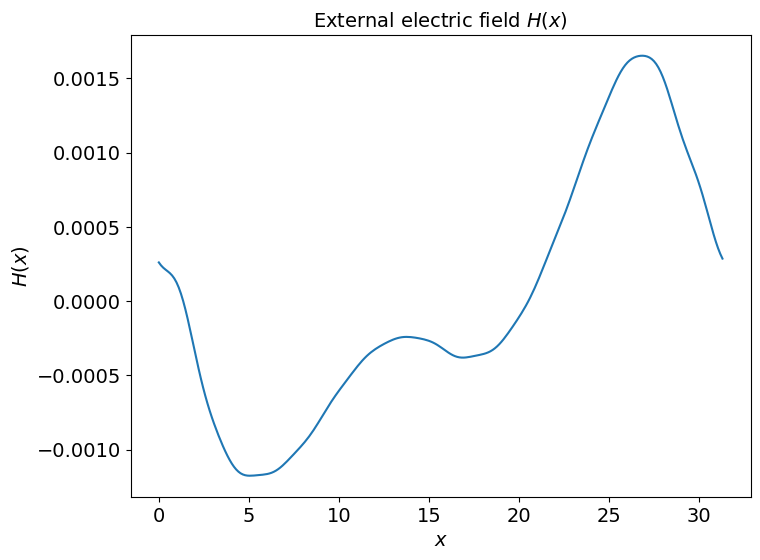

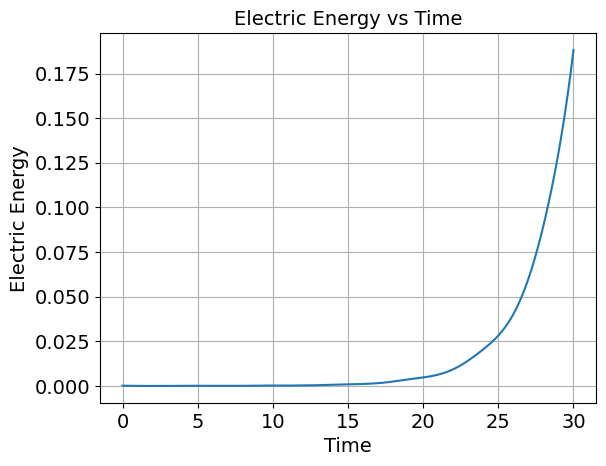

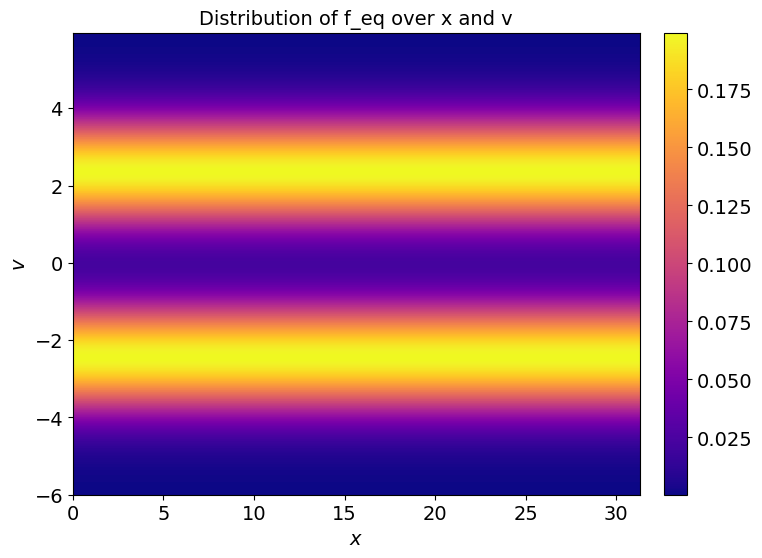

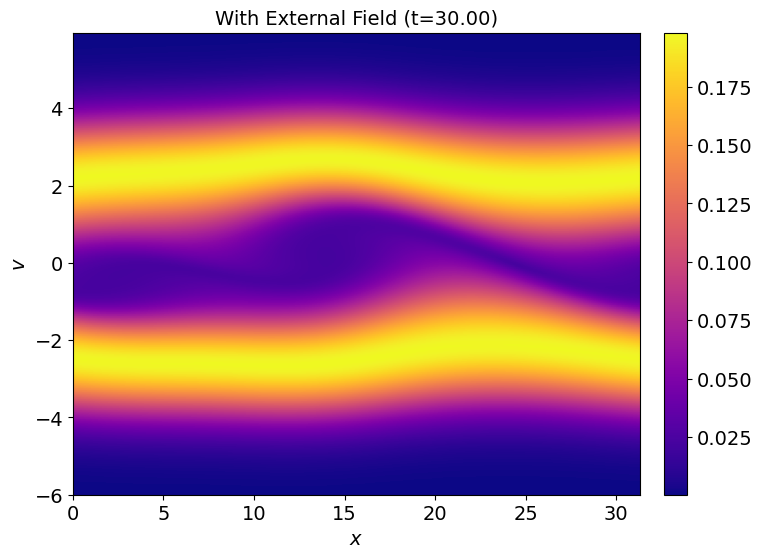

In [6]:
# Create a figure with a single plot for electric energy
fig, ax = plt.subplots(figsize=(8, 6))
t_values = jnp.linspace(0, t_final, int(t_final / dt))


plt.plot(mesh.xs, H)
plt.xlabel('$x$')
plt.ylabel('$H(x)$')
plt.title('External electric field $H(x)$')
plt.show()

plt.plot(t_values, ee_array)
plt.xlabel('Time')
plt.ylabel('Electric Energy')
plt.title('Electric Energy vs Time')
plt.grid(True)
plt.show()

# Create a figure with a single plot for f_eq
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the distribution of f_eq over x and v
plot_feq_distribution(ax, f_eq, 'Distribution of f_eq over x and v')

# Display the plot
plt.show()

# Create a figure with a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# f_array is already a 2D array, so pass it directly to the plot
plot_distribution(ax, f_array, 'With External Field', t_final)

# Display the plot
plt.show()

### Landscape search

#### $L^{2}$ objecive function

In [14]:
def compute_external_field_2d(ak, bk, mesh, k1, k2):
    H = ak * jnp.cos(k1*(mesh.xs / mesh.period_x) * 2 * jnp.pi) + bk * jnp.cos(k2*(mesh.xs / mesh.period_x) * 2 * jnp.pi)
    return H

# Adjust the J function to use f_final
def L2(f_final, solver):
    return jnp.sum((f_final - solver.f_eq) ** 2) * solver.mesh.dx * solver.mesh.dv

def cost_function_L2_2d(a_k, b_k, mesh, k1, k2):
    H = compute_external_field_2d(a_k, b_k, mesh, k1, k2)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(f_iv, H, t_final)
    #f_final = f_array
    cost = L2(f_array, solver)
    return cost



In [18]:
totals = 51
a_ks = b_ks = jnp.linspace(-0.1,0.1,totals)
A_k, B_k = jnp.meshgrid(a_ks, b_ks)
k1 = 1
k2 = 2
cost_vmapped_L2 = jax.vmap(jax.vmap(cost_function_L2_2d, in_axes=(0,0,None,None,None),out_axes=0),
                           in_axes=(1,1,None,None,None), out_axes=1)(A_k, B_k, mesh, k1, k2)

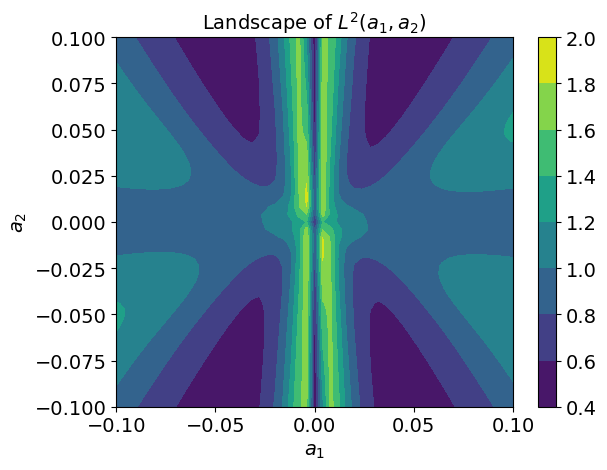

In [21]:
plt.contourf(A_k, B_k, cost_vmapped_L2)
plt.title('Landscape of $L^2(a_{},a_{})$'.format(k1,k2))
plt.xlabel('$a_{}$'.format(k1))
plt.ylabel('$a_{}$'.format(k2))
plt.colorbar()
plt.show()

#### KL objective function

In [27]:
def kl_divergence(f_final, solver, eps=1e-8):
    # Normalize the distributions so they sum to 1
    f_final = f_final / (jnp.sum(f_final) * solver.mesh.dx * solver.mesh.dv + eps)
    f_eq = solver.f_eq / (jnp.sum(solver.f_eq) * solver.mesh.dx * solver.mesh.dv + eps)
    
    # Compute KL divergence, adding eps to avoid log(0)
    kl_div = jnp.sum(jax.scipy.special.rel_entr(f_final, f_eq + eps) * solver.mesh.dx * solver.mesh.dv)
    #kl_div = jnp.sum(f_final * jnp.log(f_final / (f_eq + eps) + eps)) * solver.mesh.dx * solver.mesh.dv
    return kl_div

def compute_external_field_2d(ak, bk, mesh, k1, k2):
    H = ak * jnp.cos(k1*(mesh.xs / mesh.period_x) * 2 * jnp.pi) + bk * jnp.cos(k2*(mesh.xs / mesh.period_x) * 2 * jnp.pi)
    return H


def cost_function_kl_2d(a_k, b_k, mesh, k1, k2):
    H = compute_external_field_2d(a_k, b_k, mesh, k1, k2)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    #f_final = f_array
    cost = kl_divergence(f_array, solver)
    return cost

In [28]:
totals = 51
a_ks = b_ks = jnp.linspace(-0.1,0.1,totals)
A_k, B_k = jnp.meshgrid(a_ks, b_ks)
k1 = 1
k2 = 2
cost_vmapped_kl = jax.vmap(jax.vmap(cost_function_kl_2d, in_axes=(0,0,None,None,None),out_axes=0),
                           in_axes=(1,1,None,None,None), out_axes=1)(A_k, B_k, mesh, k1, k2)

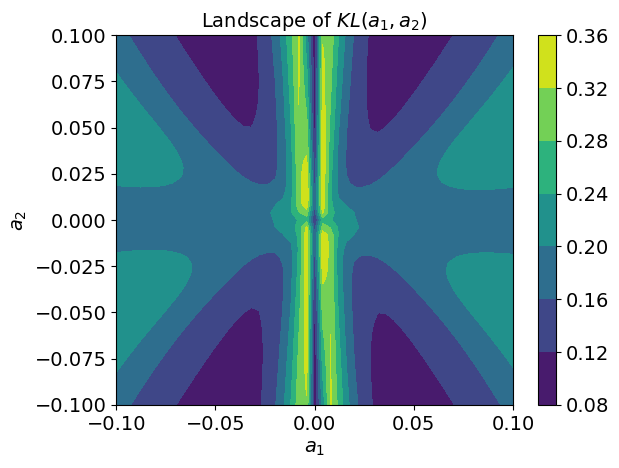

In [30]:
plt.contourf(A_k, B_k, cost_vmapped_kl)
plt.title('Landscape of $KL(a_{},a_{})$'.format(k1,k2))
plt.xlabel('$a_{}$'.format(k1))
plt.ylabel('$a_{}$'.format(k2))
plt.colorbar()
plt.show()

#### Electric Energy objective function

In [34]:
def electric_energy_opt(ee_array, solver):
    return jnp.sum(ee_array)*solver.dt


def compute_external_field_2d(ak, bk, mesh, k1, k2):
    H = ak * jnp.cos(k1*(mesh.xs / mesh.period_x) * 2 * jnp.pi) + bk * jnp.cos(k2*(mesh.xs / mesh.period_x) * 2 * jnp.pi)
    return H

def cost_function_ee_2d(a_k, b_k, mesh, k1, k2):
    H = compute_external_field_2d(a_k, b_k, mesh, k1, k2)
    # JIT-compiled forward solver
    #solver_jit = jax.jit(solver.run_forward_jax_scan, static_argnames=('t_final',))
    f_array, E_array, ee_array = solver_jit(jnp.array(f_iv), jnp.array(H), t_final)
    #f_final = f_array
    cost = electric_energy_opt(ee_array, solver)
    return cost

In [35]:
totals = 51
a_ks = b_ks = jnp.linspace(-0.1,0.1,totals)
A_k, B_k = jnp.meshgrid(a_ks, b_ks)
k1 = 1
k2 = 2
cost_vmapped_ee = jax.vmap(jax.vmap(cost_function_ee_2d, in_axes=(0,0,None,None,None),out_axes=0),
                           in_axes=(1,1,None,None,None), out_axes=1)(A_k, B_k, mesh, k1, k2)

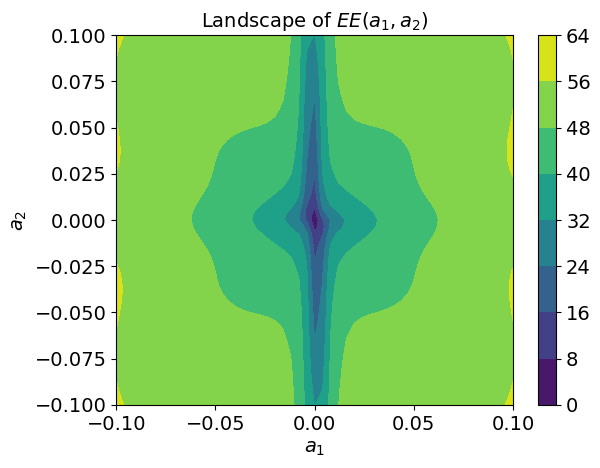

In [36]:
plt.contourf(A_k, B_k, cost_vmapped_ee)
plt.title('Landscape of $EE(a_{},a_{})$'.format(k1,k2))
plt.xlabel('$a_{}$'.format(k1))
plt.ylabel('$a_{}$'.format(k2))
plt.colorbar()
plt.show()